In [1]:
# Ref. http://nbviewer.jupyter.org/github/blei-lab/edward/blob/master/notebooks/getting_started.ipynb

In [2]:
# Probabilistic modeling in Edward uses a simple language of random variables. 

In [3]:
%matplotlib inline
from __future__ import absolute_import, division, print_function

In [4]:
import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [24]:
tf.__version__ # be sure you use this version

'1.3.0'

In [5]:
from edward.models import Normal

In [6]:
plt.style.use('ggplot')

In [8]:
# ?plt.style.use()

In [9]:
def build_toy_dataset(N=50, noise_std=0.1):
    x = np.linspace(-3, 3, num=N)
    y = np.cos(x) + np.random.normal(0, noise_std, size=N)
    x = x.astype(np.float32).reshape((N, 1))
    y = y.astype(np.float32)
    return x, y

In [10]:
def neural_network(x, W_0, W_1, b_0, b_1):
    h = tf.tanh(tf.matmul(x, W_0) + b_0)
    h = tf.matmul(h, W_1) + b_1
    return tf.reshape(h, [-1])

In [11]:
ed.set_seed(42)

N=50  #number of data points
D=1 # number of features 

In [12]:
x_train, y_train = build_toy_dataset(N)

In [13]:
x_train.shape, y_train.shape

((50, 1), (50,))

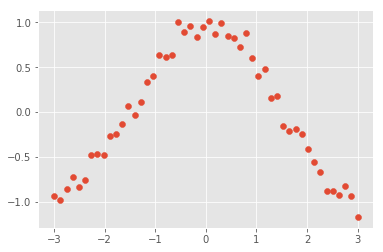

In [14]:
plt.scatter(x_train, y_train)
plt.show()

In [15]:
W_0 = Normal(loc=tf.zeros([D, 2]), scale=tf.ones([D, 2]))
W_1 = Normal(loc=tf.zeros([2, 1]), scale=tf.ones([2, 1]))
b_0 = Normal(loc=tf.zeros(2), scale=tf.ones(2))
b_1 = Normal(loc=tf.zeros(1), scale=tf.ones(1))

In [16]:
x = x_train

In [17]:
y = Normal(loc=neural_network(x, W_0, W_1, b_0, b_1),
          scale=0.1 * tf.ones(N))

In [18]:
y

<ed.RandomVariable 'Normal_4/' shape=(50,) dtype=float32>

In [20]:
qW_0 = Normal(loc=tf.get_variable("qW_0/loc", [D, 2]),
              scale=tf.nn.softplus(tf.get_variable("qW_0/scale", [D, 2])))
qW_1 = Normal(loc=tf.get_variable("qW_1/loc", [2, 1]),
              scale=tf.nn.softplus(tf.get_variable("qW_1/scale", [2, 1])))
qb_0 = Normal(loc=tf.get_variable("qb_0/loc", [2]),
              scale=tf.nn.softplus(tf.get_variable("qb_0/scale", [2])))
qb_1 = Normal(loc=tf.get_variable("qb_1/loc", [1]),
              scale=tf.nn.softplus(tf.get_variable("qb_1/scale", [1])))

In [21]:
rs = np.random.RandomState(0)

inputs = np.linspace(-5, 5, num=400, dtype=np.float32)

x = tf.expand_dims(inputs, 1)

In [22]:
mus = tf.stack(
    [neural_network(x, qW_0.sample(), qW_1.sample(), qb_0.sample(), qb_1.sample()) for _ in range(10)])

In [25]:
# First visualization (prior)

sess = ed.get_session()
tf.global_variables_initializer().run()
outputs = mus.eval()


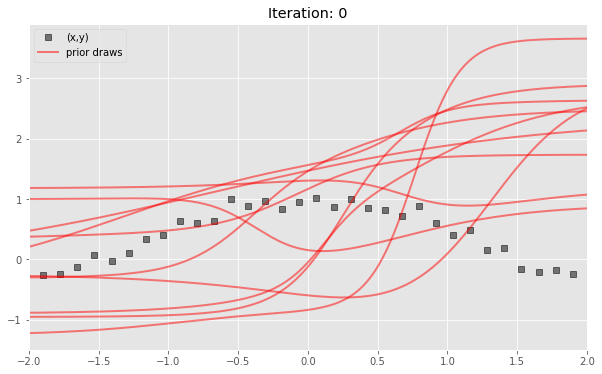

In [26]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_title('Iteration: 0')
ax.plot(x_train, y_train, 'ks', alpha=0.5, label='(x,y)')
ax.plot(inputs, outputs[0].T, 'r', lw=2, alpha=0.5, label='prior draws')
ax.plot(inputs, outputs[1:].T, 'r', lw=2, alpha=0.5)
ax.set_xlim([-5,5])
ax.set_xlim([-2,2])
ax.legend()
plt.show()

In [27]:
inference = ed.KLqp({W_0: qW_0, b_0: qb_0, 
                     W_1: qW_1, b_1: qb_1}, data={y: y_train})

/home/ivan/Environments/PGM/lib/python3.5/site-packages/edward/util/random_variables.py:53: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


In [28]:
inference.run(n_iter=1000, n_samples=5)

1000/1000 [100%] ██████████████████████████████ Elapsed: 7s | Loss: -18.777


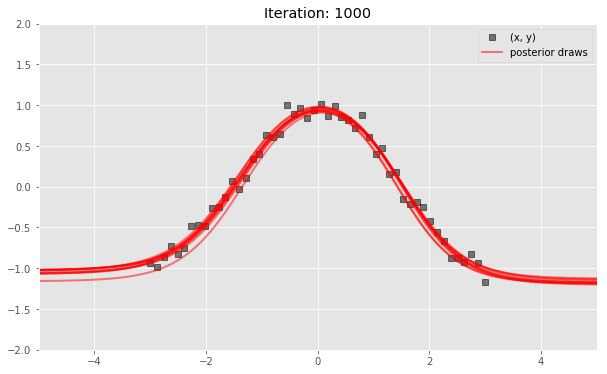

In [29]:
# second visualization (posterior)

outputs = mus.eval()

fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(111)
ax.set_title("Iteration: 1000")
ax.plot(x_train, y_train, 'ks', alpha=0.5, label='(x, y)')
ax.plot(inputs, outputs[0].T, 'r', lw=2, alpha=0.5, label='posterior draws')
ax.plot(inputs, outputs[1:].T, 'r', lw=2, alpha=0.5)
ax.set_xlim([-5, 5])
ax.set_ylim([-2, 2])
ax.legend()
plt.show()

In [30]:
# The model has captured the cosine relationship between x and y in the observed domain.